# Libraries import

In [23]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model persistence
from joblib import dump, load

# Datasets
from sklearn.datasets import load_digits, \
                             fetch_california_housing 

# Machine Learning
from sklearn.neighbors import KNeighborsClassifier, \
                              KNeighborsRegressor
from sklearn.pipeline import Pipeline   
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            plot_confusion_matrix, \
                            explained_variance_score, \
                            r2_score
from sklearn.model_selection import GridSearchCV, \
                                    RandomizedSearchCV, \
                                    train_test_split 

# Auxiliary functions

# Nearest Neighbors Classification

In [24]:
# convert sklearn dataset to pandas dataset
sklearn_dataset = load_digits()
df = pd.DataFrame(sklearn_dataset.data)
df['target'] = pd.Series(sklearn_dataset.target)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [25]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # shuffle and holdout (0.2/0.8)

y_train = np.array(train['target'])
y_test = np.array(test['target'])

X_train = np.array(train.drop(columns=['target']))
X_test = np.array(test.drop(columns=['target']))

print('X_train shape:' + str(X_train.shape))
print('X_test shape:' + str(X_test.shape))

X_train shape:(1437, 64)
X_test shape:(360, 64)


In [26]:
def run(clf, X_train, X_test, y_train, y_test):
  param_dist = {'n_neighbors': np.arange(start=1, step=2, stop=23),
                'weights': ['uniform', 'distance'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'], # 'auto'
                'leaf_size': np.array([100]), # https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/#Scaling-with-Leaf-Size
                'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                'n_jobs': np.array([-1]),
                }

  model = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10)
  model = model.fit(X_train, y_train)
  predictions = model.predict(X_test)

  print('Best params: ' + str(model.best_params_))
  print('Best score: ' + str(model.best_score_))
  print('Best estimator: ' + str(model.best_estimator_))
  print(classification_report(y_test, predictions))
  #print(confusion_matrix(y_test, predictions))
  plot_confusion_matrix(model, X_test, y_test, cmap='gray', values_format='d')  
  plt.show()  
  return model

Best params: {'weights': 'distance', 'n_neighbors': 1, 'n_jobs': -1, 'metric': 'minkowski', 'leaf_size': 100, 'algorithm': 'kd_tree'}
Best score: 0.9860820751064654
Best estimator: KNeighborsClassifier(algorithm='kd_tree', leaf_size=100, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='distance')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       0.97      1.00      0.99        34
           4       0.98      0.98      0.98        46
           5       0.98      0.98      0.98        47
           6       0.97      1.00      0.99        35
           7       1.00      0.97      0.99        34
           8       1.00      0.93      0.97        30
           9       0.95      0.93      0.94        40

    accuracy                     

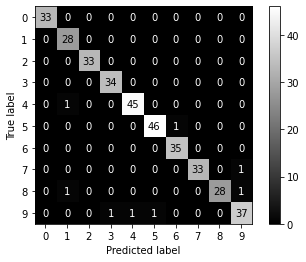

In [27]:
model = run(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

In [28]:
dump(model, 'knn_classifier.joblib') 
#load('knn_classifier.joblib')

['knn_classifier.joblib']

# Nearest Neighbors Regression

In [29]:
# convert sklearn dataset to pandas dataset
sklearn_dataset = fetch_california_housing()
df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
df['target'] = pd.Series(sklearn_dataset.target)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [30]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # shuffle and holdout (0.2/0.8)

y_train = np.array(train['target'])
y_test = np.array(test['target'])

X_train = np.array(train.drop(columns=['target']))
X_test = np.array(test.drop(columns=['target']))

print('X_train shape:' + str(X_train.shape))
print('X_test shape:' + str(X_test.shape))

X_train shape:(16512, 8)
X_test shape:(4128, 8)


In [36]:
def run(clf, X_train, X_test, y_train, y_test):
  steps = [('scaler', StandardScaler()), ('clf', clf)] 
  pipeline = Pipeline(steps)
  param_dist = {'clf__n_neighbors': np.arange(start=1, step=2, stop=23),
                'clf__weights': ['uniform', 'distance'],
                'clf__algorithm': ['ball_tree', 'kd_tree'], # 'auto'
                'clf__leaf_size': np.array([300]), # https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/#Scaling-with-Leaf-Size
                'clf__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                'clf__n_jobs': np.array([-1]),
                }

  model = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10)
  model = model.fit(X_train, y_train)
  predictions = model.predict(X_test)

  explained_variance_score, \
                            r2_score
  print('Best params: ' + str(model.best_params_))
  print('Best score: ' + str(model.best_score_))
  print('Best estimator: ' + str(model.best_estimator_))
  print('Variance score: ' + str(explained_variance_score(y_test, predictions)))
  print('R2 score: ' + str(r2_score(y_test, predictions)))
  return model

In [37]:
model = run(KNeighborsRegressor(), X_train, X_test, y_train, y_test)

Best params: {'clf__weights': 'distance', 'clf__n_neighbors': 15, 'clf__n_jobs': -1, 'clf__metric': 'manhattan', 'clf__leaf_size': 300, 'clf__algorithm': 'ball_tree'}
Best score: 0.7291222699021203
Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsRegressor(algorithm='ball_tree', leaf_size=300,
                                     metric='manhattan', metric_params=None,
                                     n_jobs=-1, n_neighbors=15, p=2,
                                     weights='distance'))],
         verbose=False)
Variance score: 0.7206750260127961
R2 score: 0.720514343494771


In [33]:
dump(model, 'knn_regressor.joblib') 
#load('knn_regressor.joblib')

['knn_regressor.joblib']